In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import confusion_matrix
import torch.optim.lr_scheduler as lr_scheduler
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class MyDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform
        self.str_mapping = {'walk': 0, 'fast': 1, 'run': 2} # Map actions to corresponding numeric codes

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features[idx].astype(np.float32)
        label = self.str_mapping[self.labels[idx]]
        features = features.reshape(1, features.shape[0])

        if self.transform:
            features = self.transform(features)

        return features, label

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data/out.csv')
X = data.iloc[:, :-1].values    # Features
y = data.iloc[:, -1].values   # Labels

# Training set features, test set features, training set labels, test set labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% test

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

No GPU available, using CPU instead.
Accuracy of the network on the test data: 97 %
[[1647    8    1]
 [   0 1485   81]
 [   0   55 1597]]


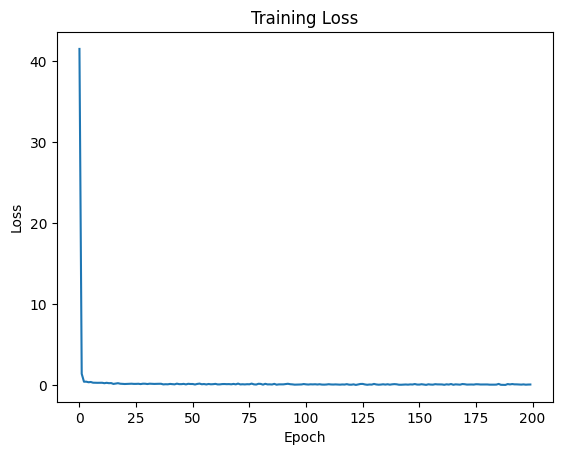

In [ ]:
class CNNP(nn.Module):
    def __init__(self):
        super(CNNP, self).__init__()
        # Define the first convolutional layer (Conv1D): receives 1 input channel, outputs 32 feature maps, kernel size is 3, using padding=1 to keep the input length unchanged
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)

        # Define the second convolutional layer (Conv1D): receives 32 input channels, outputs 64 feature maps, kernel size is 3, using padding=1 to keep the input length unchanged
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)

        # Define the pooling layer (MaxPool1D): window size is 2, used to reduce the length of the feature maps
        self.pool = nn.MaxPool1d(2)

        # Define the first fully connected layer: receives flattened features (64 channels), outputs 128-dimensional features
        self.fc1 = nn.Linear(64 * 1, 128)  # Assuming the final flattened feature length is 1

        # Define the second fully connected layer: receives 128-dimensional features, outputs 3 classes for final classification
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # First convolutional layer + ReLU activation function + Max pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Second convolutional layer + ReLU activation function + Max pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the multi-dimensional features into a 1D vector for input to the fully connected layers
        x = x.view(x.size(0), -1)

        # First fully connected layer + ReLU activation function
        x = F.relu(self.fc1(x))

        # Second fully connected layer (outputs classification results, without Softmax, as the subsequent loss function will handle it)
        x = self.fc2(x)

        return x

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU for training.")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead.")

model = CNNP()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

train_losses = []

# Train the model
for epoch in range(200):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # Clear gradients of model parameters
        output = model(data) # Input data into the model to get the model's output
        loss = criterion(output, target) # Calculate the loss between the model's output and the true labels
        loss.backward() # Backpropagate the loss to calculate the gradients of model parameters
        optimizer.step() # Update model parameters to reduce the loss
    train_losses.append(loss.item()) # Add loss value for each epoch

model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1) # Get the predicted class from the model
        total += target.size(0) # Update the total number of samples
        correct += (predicted == target).sum().item() # Update the number of correct predictions
        all_preds.extend(predicted.cpu().numpy()) # Add prediction results to the list
        all_targets.extend(target.cpu().numpy()) # Add true labels to the list

print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
print(cm)

# Line plot
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data/concatenated_out.csv')
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values    # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% test

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [ ]:
class CNNORI(nn.Module):
    def __init__(self):
        super(CNNORI, self).__init__()
        # Define the first convolutional layer (Conv1D): receives 1 input channel, outputs 32 feature maps, kernel size is 2, using padding=1 to keep the input length unchanged
        self.conv1 = nn.Conv1d(1, 32, kernel_size=2, padding=1)

        # Define the second convolutional layer (Conv1D): receives 32 input channels, outputs 64 feature maps, kernel size is 2, using padding=1 to keep the input length unchanged
        self.conv2 = nn.Conv1d(32, 64, kernel_size=2, padding=1)

        # Define the pooling layer (MaxPool1D): window size is 2, used to reduce the length of the feature maps
        self.pool = nn.MaxPool1d(2)

        # Define the first fully connected layer: receives flattened features (64 channels), outputs 128-dimensional features
        self.fc1 = nn.Linear(64 * 1, 128)

        # Define the second fully connected layer: receives 128-dimensional features, outputs 3 classes for final classification
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # First convolutional layer + ReLU activation function + Max pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Second convolutional layer + ReLU activation function + Max pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the multi-dimensional features into a 1D vector for input to the fully connected layers
        x = x.view(x.size(0), -1)

        # First fully connected layer + ReLU activation function
        x = F.relu(self.fc1(x))

        # Second fully connected layer (outputs classification results, without Softmax, as the subsequent loss function will handle it)
        x = self.fc2(x)

        return x

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU for training.")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead.")

model = CNNORI()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

train_losses = []

# Train the model
for epoch in range(100):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step(loss)
    train_losses.append(loss.item())

model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))

cm = confusion_matrix(all_targets, all_preds)
print(cm)

plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()